#Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras as ks
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D
from tensorflow.keras import models

from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset

 99% 745M/750M [00:05<00:00, 133MB/s]
100% 750M/750M [00:05<00:00, 148MB/s]


In [ ]:
!unzip -q "/content/stanford-dogs-dataset.zip"

In [ ]:
!unzip -q '/content/drive/Shareddrives/MIRCV Project/mirflickr25k.zip' -d '/content'

In [ ]:
!unzip -q '/content/drive/Shareddrives/MIRCV Project/test.zip'

In [ ]:
fpath = '/content/images/Images'
categories = os.listdir(fpath)

In [ ]:
imgsize = 224
batch_size = 64
n_classes = 120

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
ds_test = image_dataset_from_directory('/content/test',
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       image_size=(imgsize, imgsize),
                                       shuffle=False,
                                       seed=42,
                                       )

Found 2058 files belonging to 120 classes.


In [ ]:
ds_train = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       image_size=(imgsize, imgsize),
                                       shuffle=True,
                                       seed=42,
                                       validation_split=0.2,
                                       subset='training',
                                       )

val_test = image_dataset_from_directory(fpath,
                                       labels='inferred',
                                       label_mode='categorical',
                                       color_mode="rgb",
                                       batch_size=batch_size,
                                       image_size=(imgsize, imgsize),
                                       shuffle=True,
                                       seed=42,
                                       validation_split=0.2,
                                       subset='validation',
                                       )

#val_test = val_test.shuffle(64, reshuffle_each_iteration=False, seed=45)
#ds_test = val_test.skip(32)
#ds_val = val_test.take(32)




Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
!unzip -q ""

In [ ]:
file_paths = ds_train.file_paths

In [ ]:
file_paths2 = val_test.file_paths

In [ ]:
with open("file_paths_all_dogs.pkl", "wb") as fp:  # Pickling
  pickle.dump(file_paths, fp)

In [ ]:
with open("val_test_paths.pkl", "wb") as fp:  # Pickling
  pickle.dump(file_paths2, fp)

In [ ]:
distractor_images = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/mirflickr25k/mirflickr',
    image_size = (imgsize, imgsize),
    batch_size = batch_size,
    seed=42,
    labels=None,
    label_mode=None)

Found 25000 files belonging to 1 classes.


In [ ]:
import numpy as np

print(len(np.concatenate([i for x, i in ds_val], axis=0))) #count number of elements in ds_val

print(len(np.concatenate([i for x, i in ds_test], axis=0)))

2048
2068


#Utilities

In [ ]:
def evaluate_model (model):
  '''
  evaluate_model is used to show some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(ds_test)
  y_pred = np.argmax(y_score, axis=1)
  print(y_pred)
  #y_true = tf.concat([np.argmax(labels_batch, axis=1) for data_batch, labels_batch in ds_test], axis = 0)
  true_categories = tf.concat([y for x, y in ds_test], axis = 0).numpy()
  true_categories_argmax = np.argmax(true_categories, axis = 1)
  print(true_categories_argmax)
  #confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
  #print("Confusion matrix: ")
  #print(confusion_matrix)
  print("Classification report: ")
  print(metrics.classification_report(true_categories_argmax,y_pred,digits = 4))

In [ ]:
def fine_tuning(num_of_blocks=1):
    if num_of_blocks < 1:
        num_of_blocks = 1

    res = conv_base()
    res.trainable = True
    set_trainable = False

    if num_of_blocks == 1:
        block_name = 'conv5_block2_out'
    elif num_of_blocks == 2:
        block_name = 'conv5_block1_out'
    elif num_of_blocks == 3:
        block_name = 'conv4_block6_out'
    elif num_of_blocks == 4:
        block_name = 'conv4_block5_out'
    elif num_of_blocks == 5:
        block_name = 'conv4_block4_out'
    elif num_of_blocks == 6:
        block_name = 'conv4_block3_out'
    else:
        block_name = 'conv4_block2_out'

    for layer in res.layers:
        if layer.name == block_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    return res

In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1, fill_mode="nearest"),
        layers.RandomZoom(height_factor=(0.0, -0.1)),
    ]
)

In [ ]:
def input(data_augmentation=None):
    inputs = ks.Input(shape=(224, 224, 3))
    x = ks.applications.resnet50.preprocess_input(inputs)
    if data_augmentation is not None:
        x = data_augmentation(x)
    return x

In [ ]:
inputs = ks.Input(shape=(224, 224, 3))
inputs = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)

# ResNet50 Features extraction

In [ ]:
def resnet50_feature_extraction(data_augmentation=None):
    inputs = input(data_augmentation)
    outputs = conv_base()(inputs)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet50_feature_extraction()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
features = resnet50_feature_extraction().predict(ds_train, batch_size=batch_size, verbose=True)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
features.shape

(16464, 2048)

Save features:

In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet50/training/features_tr.npy', features)

Features for test set:

In [ ]:
features = model.predict(ds_test, batch_size=batch_size, verbose=True)

33/33 [==============================] - 20s 349ms/step


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet50/test/features_ts.npy', features)

Features for distractor set:

In [ ]:
features = model.predict(distractor_images, batch_size=batch_size, verbose=True)

391/391 [==============================] - 142s 355ms/step


In [ ]:
np.save('/content/drive/Shareddrives/MIRCV Project/ResNet50/distractor/features_dis.npy', features)

#Predictions

In [ ]:
##modeling
def conv_base():
  base_model = ResNet50(include_top=False,
                    input_shape = (imgsize,imgsize,3),
                    weights = 'imagenet',
                    pooling='avg')

  base_model.trainable = False
  base_model.summary()
  return base_model

In [ ]:
base_model = conv_base()
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(224, 224, 3)))
model.add(data_augmentation)
model.add(base_model)
model.add(Dense(n_classes,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = [ES])

Epoch 1/40
258/258 [==============================] - 147s 509ms/step - loss: 2.7235 - accuracy: 0.3447 - val_loss: 1.7455 - val_accuracy: 0.5249
Epoch 2/40
258/258 [==============================] - 128s 494ms/step - loss: 1.6318 - accuracy: 0.5525 - val_loss: 1.5621 - val_accuracy: 0.5698
Epoch 3/40
258/258 [==============================] - 128s 493ms/step - loss: 1.3609 - accuracy: 0.6155 - val_loss: 1.5302 - val_accuracy: 0.5874
Epoch 4/40
258/258 [==============================] - 128s 493ms/step - loss: 1.1962 - accuracy: 0.6579 - val_loss: 1.5392 - val_accuracy: 0.5806
Epoch 5/40
258/258 [==============================] - 128s 494ms/step - loss: 1.0798 - accuracy: 0.6885 - val_loss: 1.4519 - val_accuracy: 0.5967
Epoch 6/40
258/258 [==============================] - 128s 493ms/step - loss: 0.9793 - accuracy: 0.7159 - val_loss: 1.4769 - val_accuracy: 0.6045
Epoch 7/40
258/258 [==============================] - 128s 493ms/step - loss: 0.9041 - accuracy: 0.7371 - val_loss: 1.4963 -

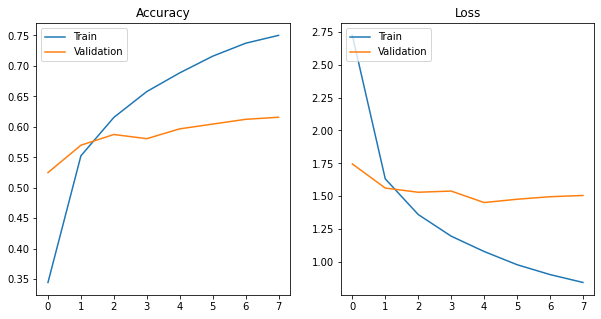

Best Validation Accuracy: 61.572265625%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/ResNet50_exp0.h5')

In [ ]:
from sklearn import metrics
evaluate_model(model)

[  0   0  57 ... 119 119  94]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.5000    0.5385    0.5185        13
           1     0.9091    0.7407    0.8163        27
           2     0.9375    0.6818    0.7895        22
           3     0.6667    0.6667    0.6667        18
           4     0.4333    0.5909    0.5000        22
           5     0.7368    0.7368    0.7368        19
           6     0.8095    1.0000    0.8947        17
           7     0.5455    0.4286    0.4800        14
           8     0.6000    0.3529    0.4444        17
           9     0.7381    1.0000    0.8493        31
          10     0.5357    0.7895    0.6383        19
          11     0.6667    0.6364    0.6512        22
          12     0.5333    0.4706    0.5000        17
          13     0.4737    0.6000    0.5294        15
          14     0.7500    0.6667    0.7059        18
          15     0.4706    0.6667    0.5517        

In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 471ms/step - loss: 1.4691 - accuracy: 0.6016


[1.4690675735473633, 0.6015549302101135]

In [ ]:
tf.keras.models.save_model(model, filepath='ResNet50_exp0.h5')

#Fine tuning from block4_conv5_out

In [ ]:
model = finetuned_resnet50(120, num_of_blocks=4, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model1.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 170s 626ms/step - loss: 2.2001 - accuracy: 0.4247 - val_loss: 1.9532 - val_accuracy: 0.4658
Epoch 2/40
258/258 [==============================] - 159s 612ms/step - loss: 1.0030 - accuracy: 0.6986 - val_loss: 1.5785 - val_accuracy: 0.5723
Epoch 3/40
258/258 [==============================] - 158s 607ms/step - loss: 0.4812 - accuracy: 0.8540 - val_loss: 1.7138 - val_accuracy: 0.5728
Epoch 4/40
258/258 [==============================] - 157s 606ms/step - loss: 0.2247 - accuracy: 0.9392 - val_loss: 1.8560 - val_accuracy: 0.5557
Epoch 5/40
258/258 [==============================] - 157s 606ms/step - loss: 0.1650 - accuracy: 0.9566 - val_loss: 2.1942 - val_accuracy: 0.5400
Epoch 6/40
258/258 [==============================] - 157s 606ms/step - loss: 0.1009 - accuracy: 0.9754 - val_loss: 1.7288 - val_accuracy: 0.6167
Epoch 7/40
258/258 [==============================] - 157s 606ms/step - loss: 0.0771 - accuracy: 0.9803 - val_loss: 1.9772 -

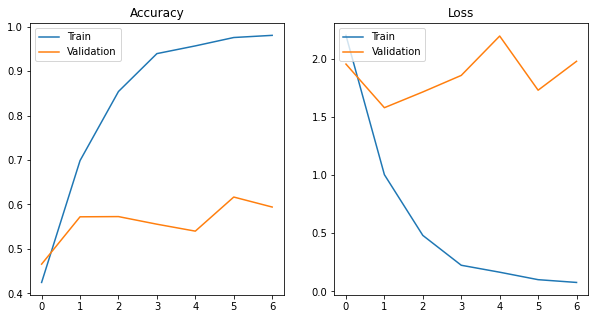

Best Validation Accuracy: 61.669921875%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model1.h5')

In [ ]:
evaluate_model(model)

[  0   0  99 ... 119 119  94]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.4615    0.4615    0.4615        13
           1     0.7105    1.0000    0.8308        27
           2     0.9375    0.6818    0.7895        22
           3     0.4054    0.8333    0.5455        18
           4     0.4815    0.5909    0.5306        22
           5     0.6923    0.9474    0.8000        19
           6     0.9286    0.7647    0.8387        17
           7     1.0000    0.2143    0.3529        14
           8     0.6667    0.1176    0.2000        17
           9     0.5952    0.8065    0.6849        31
          10     0.6316    0.6316    0.6316        19
          11     0.8333    0.4545    0.5882        22
          12     0.3409    0.8824    0.4918        17
          13     0.7059    0.8000    0.7500        15
          14     0.6923    0.5000    0.5806        18
          15     0.5000    0.2500    0.3333        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 16s 461ms/step - loss: 1.6394 - accuracy: 0.5612


[1.6393508911132812, 0.5612244606018066]

#Fine tuning entire block5

In [ ]:
model = finetuned_resnet50(120, num_of_blocks=3, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_14[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model2.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 154s 574ms/step - loss: 2.1163 - accuracy: 0.4475 - val_loss: 2.1572 - val_accuracy: 0.4648
Epoch 2/40
258/258 [==============================] - 148s 568ms/step - loss: 0.9227 - accuracy: 0.7267 - val_loss: 1.7311 - val_accuracy: 0.5620
Epoch 3/40
258/258 [==============================] - 147s 568ms/step - loss: 0.4468 - accuracy: 0.8659 - val_loss: 1.6921 - val_accuracy: 0.5732
Epoch 4/40
258/258 [==============================] - 148s 569ms/step - loss: 0.2261 - accuracy: 0.9357 - val_loss: 1.5764 - val_accuracy: 0.5854
Epoch 5/40
258/258 [==============================] - 147s 565ms/step - loss: 0.1385 - accuracy: 0.9645 - val_loss: 1.6130 - val_accuracy: 0.6147
Epoch 6/40
258/258 [==============================] - 147s 565ms/step - loss: 0.1016 - accuracy: 0.9741 - val_loss: 1.8517 - val_accuracy: 0.5962
Epoch 7/40
258/258 [==============================] - 147s 564ms/step - loss: 0.1048 - accuracy: 0.9738 - val_loss: 1.6620 -

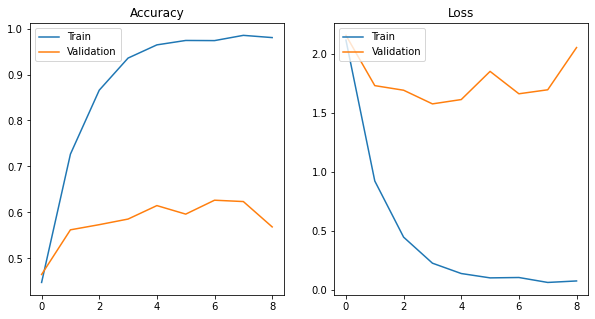

Best Validation Accuracy: 62.646484375%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model2.h5')

In [ ]:
evaluate_model(model)

[ 94   6  99 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    0.1538    0.2667        13
           1     0.8000    0.7407    0.7692        27
           2     0.6400    0.7273    0.6809        22
           3     0.6000    0.5000    0.5455        18
           4     0.5455    0.5455    0.5455        22
           5     0.5484    0.8947    0.6800        19
           6     0.4474    1.0000    0.6182        17
           7     0.4375    0.5000    0.4667        14
           8     0.5000    0.4706    0.4848        17
           9     0.7931    0.7419    0.7667        31
          10     0.4167    0.7895    0.5455        19
          11     0.5714    0.5455    0.5581        22
          12     1.0000    0.1176    0.2105        17
          13     0.6923    0.6000    0.6429        15
          14     0.7000    0.7778    0.7368        18
          15     0.3846    0.4167    0.4000        

In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 16s 461ms/step - loss: 1.5602 - accuracy: 0.5909


[1.560207486152649, 0.590864896774292]

#Fine tuning 1 block

In [ ]:
model = finetuned_resnet50(120, 1, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model3.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 154s 511ms/step - loss: 2.0019 - accuracy: 0.4749 - val_loss: 1.9199 - val_accuracy: 0.5537
Epoch 2/40
258/258 [==============================] - 129s 494ms/step - loss: 0.9328 - accuracy: 0.7178 - val_loss: 1.7539 - val_accuracy: 0.5581
Epoch 3/40
258/258 [==============================] - 127s 488ms/step - loss: 0.5264 - accuracy: 0.8381 - val_loss: 1.8038 - val_accuracy: 0.5386
Epoch 4/40
258/258 [==============================] - 127s 490ms/step - loss: 0.2925 - accuracy: 0.9132 - val_loss: 1.6183 - val_accuracy: 0.5986
Epoch 5/40
258/258 [==============================] - 128s 492ms/step - loss: 0.1640 - accuracy: 0.9561 - val_loss: 1.5312 - val_accuracy: 0.6152
Epoch 6/40
258/258 [==============================] - 128s 491ms/step - loss: 0.0958 - accuracy: 0.9769 - val_loss: 1.5911 - val_accuracy: 0.6313
Epoch 7/40
258/258 [==============================] - 130s 502ms/step - loss: 0.1053 - accuracy: 0.9709 - val_loss: 1.7834 -

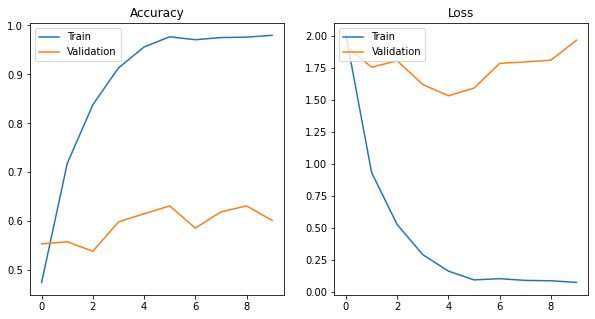

Best Validation Accuracy: 63.134765625%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model3.h5')

In [ ]:
evaluate_model(model)

[  0   0   0 ... 119 119  94]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.3750    0.6923    0.4865        13
           1     0.8500    0.6296    0.7234        27
           2     0.6923    0.8182    0.7500        22
           3     1.0000    0.2778    0.4348        18
           4     0.5294    0.4091    0.4615        22
           5     0.9000    0.4737    0.6207        19
           6     0.5357    0.8824    0.6667        17
           7     0.4091    0.6429    0.5000        14
           8     0.6667    0.2353    0.3478        17
           9     0.9286    0.8387    0.8814        31
          10     0.5357    0.7895    0.6383        19
          11     0.8571    0.5455    0.6667        22
          12     0.8000    0.7059    0.7500        17
          13     0.6316    0.8000    0.7059        15
          14     0.7500    0.8333    0.7895        18
          15     0.4667    0.5833    0.5185        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 463ms/step - loss: 1.5614 - accuracy: 0.6098


[1.5613738298416138, 0.6098153591156006]

#Fine tuning 2 blocks


In [ ]:
model = finetuned_resnet50(120, 2, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model4.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 144s 536ms/step - loss: 2.0769 - accuracy: 0.4540 - val_loss: 1.7625 - val_accuracy: 0.5122
Epoch 2/40
258/258 [==============================] - 142s 546ms/step - loss: 0.9975 - accuracy: 0.7026 - val_loss: 1.5265 - val_accuracy: 0.5820
Epoch 3/40
258/258 [==============================] - 137s 526ms/step - loss: 0.5355 - accuracy: 0.8326 - val_loss: 1.6209 - val_accuracy: 0.5752
Epoch 4/40
258/258 [==============================] - 136s 525ms/step - loss: 0.2684 - accuracy: 0.9216 - val_loss: 1.7081 - val_accuracy: 0.5737
Epoch 5/40
258/258 [==============================] - 137s 526ms/step - loss: 0.1607 - accuracy: 0.9546 - val_loss: 1.6761 - val_accuracy: 0.6118


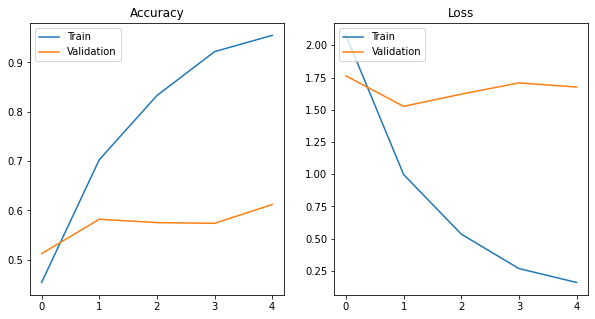

Best Validation Accuracy: 61.181640625%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model4.h5')

In [ ]:
evaluate_model(model)

[  0   0  97 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.2800    0.5385    0.3684        13
           1     0.7879    0.9630    0.8667        27
           2     0.8750    0.6364    0.7368        22
           3     0.6500    0.7222    0.6842        18
           4     0.4286    0.4091    0.4186        22
           5     0.3725    1.0000    0.5429        19
           6     0.8235    0.8235    0.8235        17
           7     1.0000    0.4286    0.6000        14
           8     0.5000    0.0588    0.1053        17
           9     0.8438    0.8710    0.8571        31
          10     0.8000    0.4211    0.5517        19
          11     1.0000    0.4091    0.5806        22
          12     0.8462    0.6471    0.7333        17
          13     0.5238    0.7333    0.6111        15
          14     1.0000    0.6111    0.7586        18
          15     0.3571    0.4167    0.3846        

In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 462ms/step - loss: 1.5295 - accuracy: 0.5845


[1.529537320137024, 0.5845481157302856]

#Fine tuning 1 block + dense

In [ ]:
def finetuned_resnet50_dense(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    x = layers.Dense(1024, activation='relu', name='dense_1')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = finetuned_resnet50_dense(120, 1, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model5.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 134s 498ms/step - loss: 2.0880 - accuracy: 0.4477 - val_loss: 1.8703 - val_accuracy: 0.5288
Epoch 2/40
258/258 [==============================] - 130s 500ms/step - loss: 1.0486 - accuracy: 0.6811 - val_loss: 1.5542 - val_accuracy: 0.5747
Epoch 3/40
258/258 [==============================] - 128s 493ms/step - loss: 0.6449 - accuracy: 0.7946 - val_loss: 1.5232 - val_accuracy: 0.6104
Epoch 4/40
258/258 [==============================] - 127s 489ms/step - loss: 0.4133 - accuracy: 0.8621 - val_loss: 1.6557 - val_accuracy: 0.6006
Epoch 5/40
258/258 [==============================] - 127s 489ms/step - loss: 0.2676 - accuracy: 0.9097 - val_loss: 1.8470 - val_accuracy: 0.5806
Epoch 6/40
258/258 [==============================] - 127s 489ms/step - loss: 0.2040 - accuracy: 0.9347 - val_loss: 1.7656 - val_accuracy: 0.6143


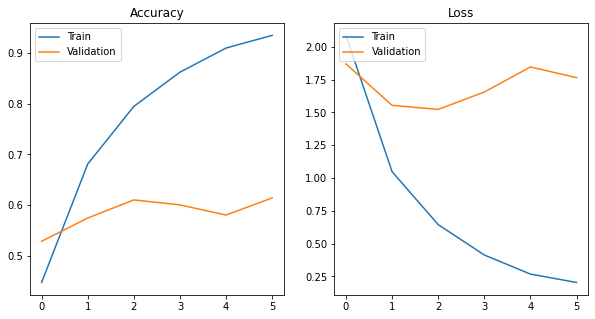

Best Validation Accuracy: 61.42578125%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model5.h5')

In [ ]:
evaluate_model(model)

[  0   0  97 ... 119 119  94]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.1475    0.6923    0.2432        13
           1     0.7667    0.8519    0.8070        27
           2     0.8333    0.6818    0.7500        22
           3     0.4571    0.8889    0.6038        18
           4     0.4615    0.5455    0.5000        22
           5     0.6957    0.8421    0.7619        19
           6     1.0000    0.6471    0.7857        17
           7     0.6364    0.5000    0.5600        14
           8     0.5556    0.2941    0.3846        17
           9     0.9286    0.8387    0.8814        31
          10     0.5417    0.6842    0.6047        19
          11     0.9091    0.4545    0.6061        22
          12     0.8000    0.4706    0.5926        17
          13     0.5789    0.7333    0.6471        15
          14     0.8750    0.7778    0.8235        18
          15     0.3077    0.3333    0.3200        

In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 463ms/step - loss: 1.6235 - accuracy: 0.5952


[1.6234779357910156, 0.5952380895614624]

#Fine tuning 2 block + dense

In [ ]:
def finetuned_resnet50_dense(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    x = layers.Dense(1024, activation='relu', name='dense_1')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = finetuned_resnet50_dense(120, 2, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model6.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 144s 537ms/step - loss: 2.1558 - accuracy: 0.4300 - val_loss: 1.6795 - val_accuracy: 0.5415
Epoch 2/40
258/258 [==============================] - 138s 532ms/step - loss: 1.1071 - accuracy: 0.6628 - val_loss: 1.6656 - val_accuracy: 0.5479
Epoch 3/40
258/258 [==============================] - 141s 540ms/step - loss: 0.6698 - accuracy: 0.7875 - val_loss: 1.7086 - val_accuracy: 0.5752
Epoch 4/40
258/258 [==============================] - 138s 532ms/step - loss: 0.4179 - accuracy: 0.8631 - val_loss: 1.6890 - val_accuracy: 0.5791
Epoch 5/40
258/258 [==============================] - 138s 530ms/step - loss: 0.2670 - accuracy: 0.9122 - val_loss: 1.9399 - val_accuracy: 0.5635


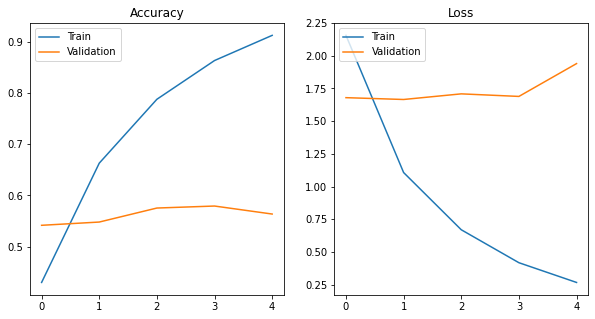

Best Validation Accuracy: 57.91015625%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model6.h5')

In [ ]:
evaluate_model(model)

[  0   6  97 ...  61 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.4286    0.4615    0.4444        13
           1     0.8846    0.8519    0.8679        27
           2     1.0000    0.5455    0.7059        22
           3     0.5789    0.6111    0.5946        18
           4     0.4444    0.5455    0.4898        22
           5     0.4146    0.8947    0.5667        19
           6     0.7000    0.8235    0.7568        17
           7     1.0000    0.4286    0.6000        14
           8     0.0000    0.0000    0.0000        17
           9     0.5000    0.9677    0.6593        31
          10     0.4250    0.8947    0.5763        19
          11     0.7857    0.5000    0.6111        22
          12     0.3333    1.0000    0.5000        17
          13     0.6000    0.8000    0.6857        15
          14     0.7619    0.8889    0.8205        18
          15     0.3333    0.0833    0.1333        

In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 18s 463ms/step - loss: 1.6479 - accuracy: 0.5520


[1.6478883028030396, 0.5519922375679016]

#Fine tuning 1 block + 2 denses

In [ ]:
def finetuned_resnet50_2denses(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    x = layers.Dense(1024, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu', name='dense_2')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = finetuned_resnet50_2denses(120, 1, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_24[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model7.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 137s 503ms/step - loss: 2.7364 - accuracy: 0.2938 - val_loss: 2.3385 - val_accuracy: 0.4160
Epoch 2/40
258/258 [==============================] - 131s 495ms/step - loss: 1.6818 - accuracy: 0.5086 - val_loss: 1.6819 - val_accuracy: 0.5459
Epoch 3/40
258/258 [==============================] - 129s 498ms/step - loss: 1.3090 - accuracy: 0.6039 - val_loss: 1.5213 - val_accuracy: 0.5620
Epoch 4/40
258/258 [==============================] - 129s 495ms/step - loss: 1.0500 - accuracy: 0.6658 - val_loss: 1.6674 - val_accuracy: 0.5640
Epoch 5/40
258/258 [==============================] - 129s 494ms/step - loss: 0.8611 - accuracy: 0.7259 - val_loss: 1.5414 - val_accuracy: 0.5820
Epoch 6/40
258/258 [==============================] - 129s 496ms/step - loss: 0.7091 - accuracy: 0.7705 - val_loss: 1.7915 - val_accuracy: 0.5752


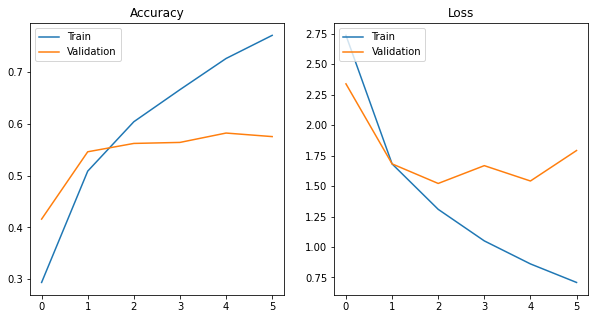

Best Validation Accuracy: 58.203125%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model7.h5')

In [ ]:
evaluate_model(model)

[  0   6  99 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.5455    0.4615    0.5000        13
           1     0.7059    0.8889    0.7869        27
           2     1.0000    0.5000    0.6667        22
           3     0.7143    0.2778    0.4000        18
           4     0.4444    0.5455    0.4898        22
           5     0.5312    0.8947    0.6667        19
           6     0.6250    0.8824    0.7317        17
           7     0.6000    0.4286    0.5000        14
           8     0.0000    0.0000    0.0000        17
           9     0.7647    0.8387    0.8000        31
          10     0.6818    0.7895    0.7317        19
          11     0.5000    0.7727    0.6071        22
          12     0.5000    0.5882    0.5405        17
          13     1.0000    0.4667    0.6364        15
          14     0.6364    0.7778    0.7000        18
          15     0.2500    0.3333    0.2857        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 464ms/step - loss: 1.5514 - accuracy: 0.5675


[1.5513790845870972, 0.5675413012504578]

#Fine tuning 2 block + 2 denses

In [ ]:
model = finetuned_resnet50_2denses(120, 2, data_augmentation=data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model8.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 143s 532ms/step - loss: 2.8065 - accuracy: 0.2853 - val_loss: 2.2473 - val_accuracy: 0.3931
Epoch 2/40
258/258 [==============================] - 140s 539ms/step - loss: 1.6993 - accuracy: 0.4983 - val_loss: 1.6484 - val_accuracy: 0.5288
Epoch 3/40
258/258 [==============================] - 140s 539ms/step - loss: 1.3059 - accuracy: 0.6033 - val_loss: 1.5353 - val_accuracy: 0.5679
Epoch 4/40
258/258 [==============================] - 137s 525ms/step - loss: 1.0039 - accuracy: 0.6832 - val_loss: 1.6052 - val_accuracy: 0.5781
Epoch 5/40
258/258 [==============================] - 137s 529ms/step - loss: 0.7975 - accuracy: 0.7459 - val_loss: 1.6727 - val_accuracy: 0.5703
Epoch 6/40
258/258 [==============================] - 138s 531ms/step - loss: 0.6138 - accuracy: 0.7977 - val_loss: 1.6622 - val_accuracy: 0.5854


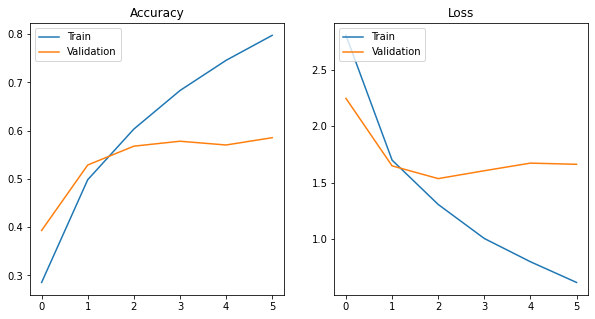

Best Validation Accuracy: 58.544921875%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model8.h5')

In [ ]:
evaluate_model(model)

[  0   6  97 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.4167    0.3846    0.4000        13
           1     0.5510    1.0000    0.7105        27
           2     0.9412    0.7273    0.8205        22
           3     0.3333    0.1111    0.1667        18
           4     0.4000    0.5455    0.4615        22
           5     0.4865    0.9474    0.6429        19
           6     0.8182    0.5294    0.6429        17
           7     0.7143    0.3571    0.4762        14
           8     0.5000    0.1765    0.2609        17
           9     0.6667    0.9032    0.7671        31
          10     0.4750    1.0000    0.6441        19
          11     0.5000    0.8182    0.6207        22
          12     0.6538    1.0000    0.7907        17
          13     0.7143    0.6667    0.6897        15
          14     0.9231    0.6667    0.7742        18
          15     0.3889    0.5833    0.4667        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 462ms/step - loss: 1.5512 - accuracy: 0.5724


[1.5511746406555176, 0.5724003911018372]

#Finetuning from conv4_block4_out

In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model9.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model = finetuned_resnet50(120, 5, data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_30[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 182s 678ms/step - loss: 2.2929 - accuracy: 0.3995 - val_loss: 2.0700 - val_accuracy: 0.4502
Epoch 2/40
258/258 [==============================] - 172s 665ms/step - loss: 1.0549 - accuracy: 0.6849 - val_loss: 1.9630 - val_accuracy: 0.4722
Epoch 3/40
258/258 [==============================] - 173s 666ms/step - loss: 0.5283 - accuracy: 0.8378 - val_loss: 1.7944 - val_accuracy: 0.5273
Epoch 4/40
258/258 [==============================] - 172s 663ms/step - loss: 0.2648 - accuracy: 0.9233 - val_loss: 1.8366 - val_accuracy: 0.5415
Epoch 5/40
258/258 [==============================] - 171s 661ms/step - loss: 0.1307 - accuracy: 0.9681 - val_loss: 1.8771 - val_accuracy: 0.5889
Epoch 6/40
258/258 [==============================] - 172s 662ms/step - loss: 0.1050 - accuracy: 0.9732 - val_loss: 2.1293 - val_accuracy: 0.5591
Epoch 7/40
258/258 [==============================] - 171s 660ms/step - loss: 0.1067 - accuracy: 0.9705 - val_loss: 1.9317 -

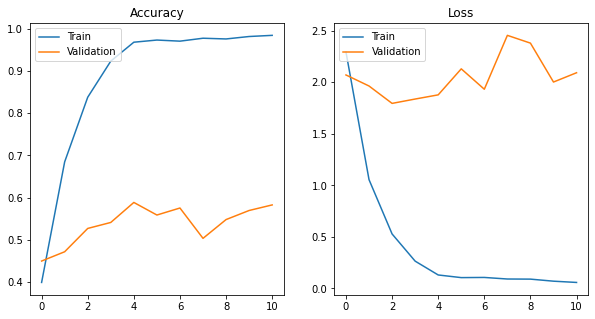

Best Validation Accuracy: 58.88671875%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model9.h5')

In [ ]:
evaluate_model(model)

[  0   0  97 ... 119 119 119]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.2128    0.7692    0.3333        13
           1     0.7500    0.7778    0.7636        27
           2     0.5357    0.6818    0.6000        22
           3     0.3939    0.7222    0.5098        18
           4     0.9000    0.4091    0.5625        22
           5     0.4286    0.7895    0.5556        19
           6     0.4444    0.9412    0.6038        17
           7     0.4615    0.4286    0.4444        14
           8     0.6000    0.1765    0.2727        17
           9     1.0000    0.5161    0.6809        31
          10     0.5556    0.5263    0.5405        19
          11     0.8750    0.3182    0.4667        22
          12     1.0000    0.4706    0.6400        17
          13     0.7500    0.6000    0.6667        15
          14     0.7500    0.5000    0.6000        18
          15     0.5000    0.2500    0.3333        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 465ms/step - loss: 1.7689 - accuracy: 0.5428


[1.768944501876831, 0.5427599549293518]

#Finetuning from conv4_block3_out



In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model10.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model = finetuned_resnet50(120, 6, data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 183s 685ms/step - loss: 0.1017 - accuracy: 0.9727 - val_loss: 1.9775 - val_accuracy: 0.5605
Epoch 2/40
258/258 [==============================] - 182s 693ms/step - loss: 0.0560 - accuracy: 0.9875 - val_loss: 1.8425 - val_accuracy: 0.5991
Epoch 3/40
258/258 [==============================] - 183s 700ms/step - loss: 0.0365 - accuracy: 0.9922 - val_loss: 1.9772 - val_accuracy: 0.6099
Epoch 4/40
258/258 [==============================] - 182s 698ms/step - loss: 0.0184 - accuracy: 0.9964 - val_loss: 1.7422 - val_accuracy: 0.6396
Epoch 5/40
258/258 [==============================] - 178s 681ms/step - loss: 0.0132 - accuracy: 0.9964 - val_loss: 1.8482 - val_accuracy: 0.6274
Epoch 6/40
258/258 [==============================] - 181s 694ms/step - loss: 0.0813 - accuracy: 0.9771 - val_loss: 2.3646 - val_accuracy: 0.5225
Epoch 7/40
258/258 [==============================] - 181s 694ms/step - loss: 0.1111 - accuracy: 0.9668 - val_loss: 2.0231 -

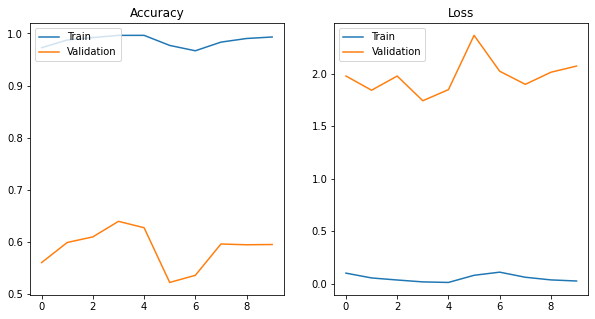

Best Validation Accuracy: 63.96484375%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model10.h5')

In [ ]:
evaluate_model(model)

[  0   6 117 ...  95 119  23]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.5556    0.3846    0.4545        13
           1     0.9167    0.8148    0.8627        27
           2     0.9000    0.4091    0.5625        22
           3     0.7500    0.5000    0.6000        18
           4     0.7059    0.5455    0.6154        22
           5     0.7333    0.5789    0.6471        19
           6     0.6667    0.7059    0.6857        17
           7     1.0000    0.5000    0.6667        14
           8     0.2667    0.2353    0.2500        17
           9     0.7500    0.6774    0.7119        31
          10     0.4419    1.0000    0.6129        19
          11     1.0000    0.0455    0.0870        22
          12     0.5484    1.0000    0.7083        17
          13     0.7778    0.4667    0.5833        15
          14     0.6800    0.9444    0.7907        18
          15     0.3500    0.5833    0.4375        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 467ms/step - loss: 1.6814 - accuracy: 0.5539


[1.6813849210739136, 0.5539358854293823]

#Finetuning from conv4_block2_out



In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model11.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model = finetuned_resnet50(120, 7, data_augmentation)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
h = model.fit(ds_train, epochs = 40, verbose = 1, 
              batch_size = batch_size, validation_data  = ds_val, 
              callbacks = callbacks_list)

Epoch 1/40
258/258 [==============================] - 209s 733ms/step - loss: 2.4652 - accuracy: 0.3653 - val_loss: 2.2489 - val_accuracy: 0.3984
Epoch 2/40
258/258 [==============================] - 190s 723ms/step - loss: 1.2008 - accuracy: 0.6404 - val_loss: 1.7597 - val_accuracy: 0.5205
Epoch 3/40
258/258 [==============================] - 186s 717ms/step - loss: 0.6260 - accuracy: 0.8075 - val_loss: 1.8211 - val_accuracy: 0.5361
Epoch 4/40
258/258 [==============================] - 186s 716ms/step - loss: 0.3227 - accuracy: 0.9017 - val_loss: 2.2146 - val_accuracy: 0.5107
Epoch 5/40
258/258 [==============================] - 186s 716ms/step - loss: 0.1857 - accuracy: 0.9489 - val_loss: 1.7958 - val_accuracy: 0.5742
Epoch 6/40
258/258 [==============================] - 186s 717ms/step - loss: 0.1254 - accuracy: 0.9678 - val_loss: 2.2826 - val_accuracy: 0.5322
Epoch 7/40
258/258 [==============================] - 186s 716ms/step - loss: 0.1006 - accuracy: 0.9730 - val_loss: 2.1150 -

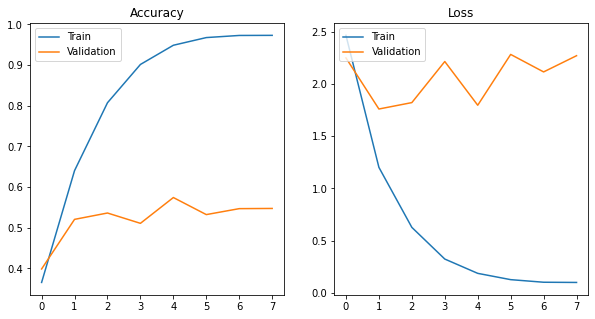

Best Validation Accuracy: 57.421875%


In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],     label = 'Train')
plt.plot(h.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.legend(loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(h.history['loss']    ,label = 'Train')
plt.plot(h.history['val_loss'],label = 'Validation')
plt.title('Loss')
plt.legend(loc = 'upper left')
plt.show()

max_val_acc = 100*np.max(h.history['val_accuracy'])
print("Best Validation Accuracy: {}%".format(max_val_acc))

In [ ]:
model = tf.keras.models.load_model('/content/drive/Shareddrives/MIRCV Project/ResNet50/model11.h5')

In [ ]:
evaluate_model(model)

[ 29   7 117 ...  25 119  23]
[  0   0   0 ... 119 119 119]
Classification report: 
              precision    recall  f1-score   support

           0     0.2500    0.1538    0.1905        13
           1     0.9600    0.8889    0.9231        27
           2     1.0000    0.5000    0.6667        22
           3     1.0000    0.5556    0.7143        18
           4     0.5909    0.5909    0.5909        22
           5     0.5833    0.7368    0.6512        19
           6     0.9167    0.6471    0.7586        17
           7     0.3636    0.2857    0.3200        14
           8     0.2857    0.2353    0.2581        17
           9     0.5435    0.8065    0.6494        31
          10     0.5185    0.7368    0.6087        19
          11     0.6111    0.5000    0.5500        22
          12     0.6316    0.7059    0.6667        17
          13     0.7692    0.6667    0.7143        15
          14     0.7273    0.4444    0.5517        18
          15     0.2857    0.3333    0.3077        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.evaluate(ds_test)

33/33 [==============================] - 17s 465ms/step - loss: 1.7763 - accuracy: 0.5209


[1.7762850522994995, 0.5208940505981445]